In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm

In [2]:
eeg_feats = np.load('EEG_features.npy',allow_pickle=True)
wavelet = eeg_feats.item().get('waveletEntropy')

In [3]:
left = np.array([0, 1, 3, 4, 8, 10, 11]) #np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array([16, 17, 20, 21, 25, 28, 29]) #np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array([2, 5, 18, 17, 22]) #np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array([10, 11, 15, 28, 29]) #np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array([13, 14, 31, 12, 30]) #np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array([8, 9, 23, 24, 6, 26, 27]) #np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [4]:
centralDWT = np.mean(wavelet[:,central,:],axis=1)
frontalDWT = np.mean(wavelet[:,frontal,:],axis=1)
occipDWT = np.mean(wavelet[:,occipital,:],axis=1)
parietDWT = np.mean(wavelet[:,parietal,:],axis=1)
print(centralDWT.shape)
dwt_names = ['cdwt1', 'cdwt2','cdwt3', 'cdwt4','cdwt5', 'cdwt6', 'fdwt1', 
             'fdwt2','fdwt3', 'fdwt4','fdwt5', 'fdwt6','odwt1', 'odwt2','odwt3', 
             'odwt4','odwt5', 'odwt6','pdwt1', 'pdwt2','pdwt3', 'pdwt4','pdwt5', 'pdwt6']
dwts = np.hstack([centralDWT, frontalDWT, occipDWT, parietDWT])
print(dwts.shape)
print(len(dwt_names))

(880, 6)
(880, 24)
24


In [43]:
feats = np.load('bipolar_feats_1_22.npy')
feat_names = feats[0,1:]
data = feats[1:,:]
data = data.astype(float)
labels = np.load('labels_1_22.npy')
y = labels[1:,:2].astype(float)
data = np.hstack([data,dwts])
feat_names = np.hstack([feat_names,dwt_names])
data = data[np.where(data[:,0]<=4)]
y = y[np.where(data[:,0]<=4)]
print(data.shape)
print(feat_names.shape)

(160, 68)
(67,)


In [44]:
print(y.shape)
print(type(data[0,0]))
print(feat_names)

(160, 2)
<class 'numpy.float64'>
['RMP1' 'RMP2' 'RMP3' 'RMP4' 'RMP5' 'RMP6' 'RMP7' 'RMP8' 'RMP9' 'RMP10'
 'RRange' 'RMeanDer' 'Rstd' 'RMeanPeak' 'Tmean' 'Tstd' 'T_der' 'HRV' 'bpm'
 'ibi' 'sdnn' 'sdsd' 'rmssd' 'pnn20' 'pnn50' 'hr_mad' 'sd1' 'sd2' 's'
 'sd1/sd2' 'breathingrate' 'Gmean' 'Gstd' 'Gskew' 'Gkurtosis' 'Gme.1absdf'
 'Gme.2absdf' 'Gme.1df' 'Gme.2df' 'Gme.negdf' 'Gro.negdf' 'Gnum.argmi'
 'Gnum.argma' 'cdwt1' 'cdwt2' 'cdwt3' 'cdwt4' 'cdwt5' 'cdwt6' 'fdwt1'
 'fdwt2' 'fdwt3' 'fdwt4' 'fdwt5' 'fdwt6' 'odwt1' 'odwt2' 'odwt3' 'odwt4'
 'odwt5' 'odwt6' 'pdwt1' 'pdwt2' 'pdwt3' 'pdwt4' 'pdwt5' 'pdwt6']


In [45]:
bad_idx = np.unique(np.where(np.isnan(data))[0])
data = np.delete(data,bad_idx,axis=0)
y = np.delete(y,bad_idx,axis=0)
bad_idx = np.unique(np.where(np.isinf(data))[0])
data = np.delete(data,bad_idx,axis=0)
y = np.delete(y,bad_idx,axis=0)
bad_idx = np.unique(np.where(data==-1)[0])
data = np.delete(data,bad_idx,axis=0)
y = np.delete(y,bad_idx,axis=0)

In [46]:
print(data.shape)
print(y.shape)

(160, 68)
(160, 2)


In [9]:

y[np.where(y<4.5)] = 0
y[np.where(y>=4.5)] = 1


In [10]:
data.shape
y_multi = y
y_valence = y_multi[:,0].reshape((y.shape[0],1))
y_arousal = y_multi[:,1].reshape((y.shape[0],1))
y.shape

(581, 2)

#Valence Binary Classifer

In [11]:
# implements leave one (subject) out cross validation
prec = []
recall = []
f1 = []
acc = []
feature_importance = []
for j in np.unique(data[:,0]):
    row_idx = data[:,0] == j
    keep_idx = ~row_idx
    x_train = data[keep_idx,1:]
    y_train = y_valence[keep_idx,0]
    x_val = data[row_idx,1:]
    y_val = y_valence[row_idx,0]
    model = RandomForestClassifier(n_estimators=1000)
    print(x_train.shape)
    print(np.unique(y_train))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    acc.append(skm.accuracy_score(y_val,y_pred))
    f1.append(skm.f1_score(y_val,y_pred))
    prec.append(skm.precision_score(y_val,y_pred))
    recall.append(skm.recall_score(y_val,y_pred))
    feature_importance.append(model.feature_importances_)
    

(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(549, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(544, 67)
[0. 1.]
(570, 67)
[0. 1.]
(566, 67)
[0. 1.]
(546, 67)
[0. 1.]
(541, 67)
[0. 1.]
(543, 67)
[0. 1.]
(558, 67)
[0. 1.]
(542, 67)
[0. 1.]
(554, 67)
[0. 1.]
(541, 67)
[0. 1.]
(577, 67)
[0. 1.]


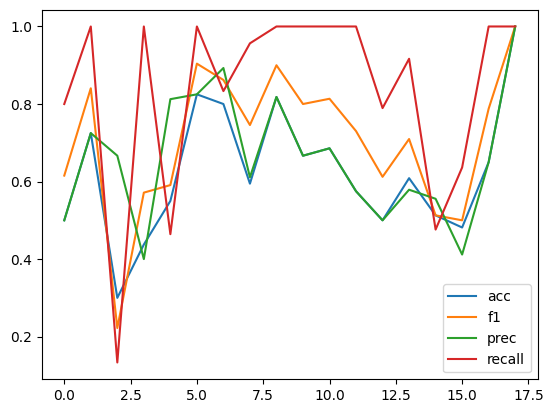

In [12]:
fig,ax = plt.subplots()
ax.plot(acc)
ax.plot(f1)
ax.plot(prec)
ax.plot(recall)
plt.legend(['acc','f1','prec','recall'])
plt.show()

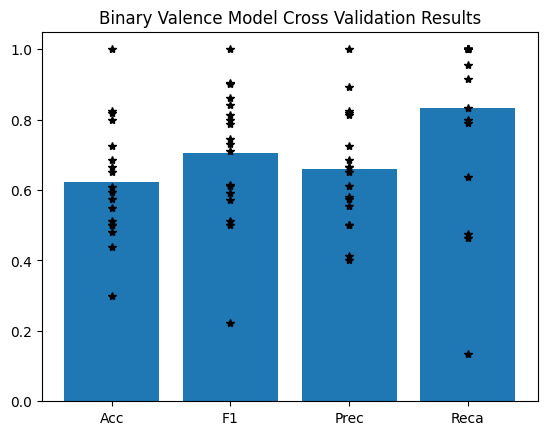

In [13]:
# plot performance results
acc_avg = np.mean(acc)
f1_avg = np.mean(f1)
prec_avg = np.mean(prec)
recall_avg = np.mean(recall)

acc_std = np.std(acc)
f1_std = np.std(f1)
prec_std = np.std(prec)
recall_std = np.std(recall)

means = [acc_avg,f1_avg,prec_avg,recall_avg]
errors = [acc_std,f1_std,prec_std,recall_std]
x_pos = np.arange(len(means))
mets = ['Acc','F1','Prec','Reca']

fig,ax = plt.subplots()
ax.bar(x_pos,means,align='center',ecolor='black',capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(mets)
ax.set_title('Binary Valence Model Cross Validation Results')
ax.plot(np.zeros((len(acc),1)),acc,'*k')
ax.plot(np.ones((len(f1),1)),f1,'*k')
ax.plot(np.ones((len(prec),1))*2,prec,'*k')
ax.plot(np.ones((len(recall),1))*3,recall,'*k')


In [14]:
subjs = np.unique(data[:,0])
print(len(subjs))
idx = np.where(np.array(acc)<.5)
print(subjs[idx])
print('mean acc:' , acc_avg)

18
[ 7.  8. 20.]
mean acc: 0.6239252784240708


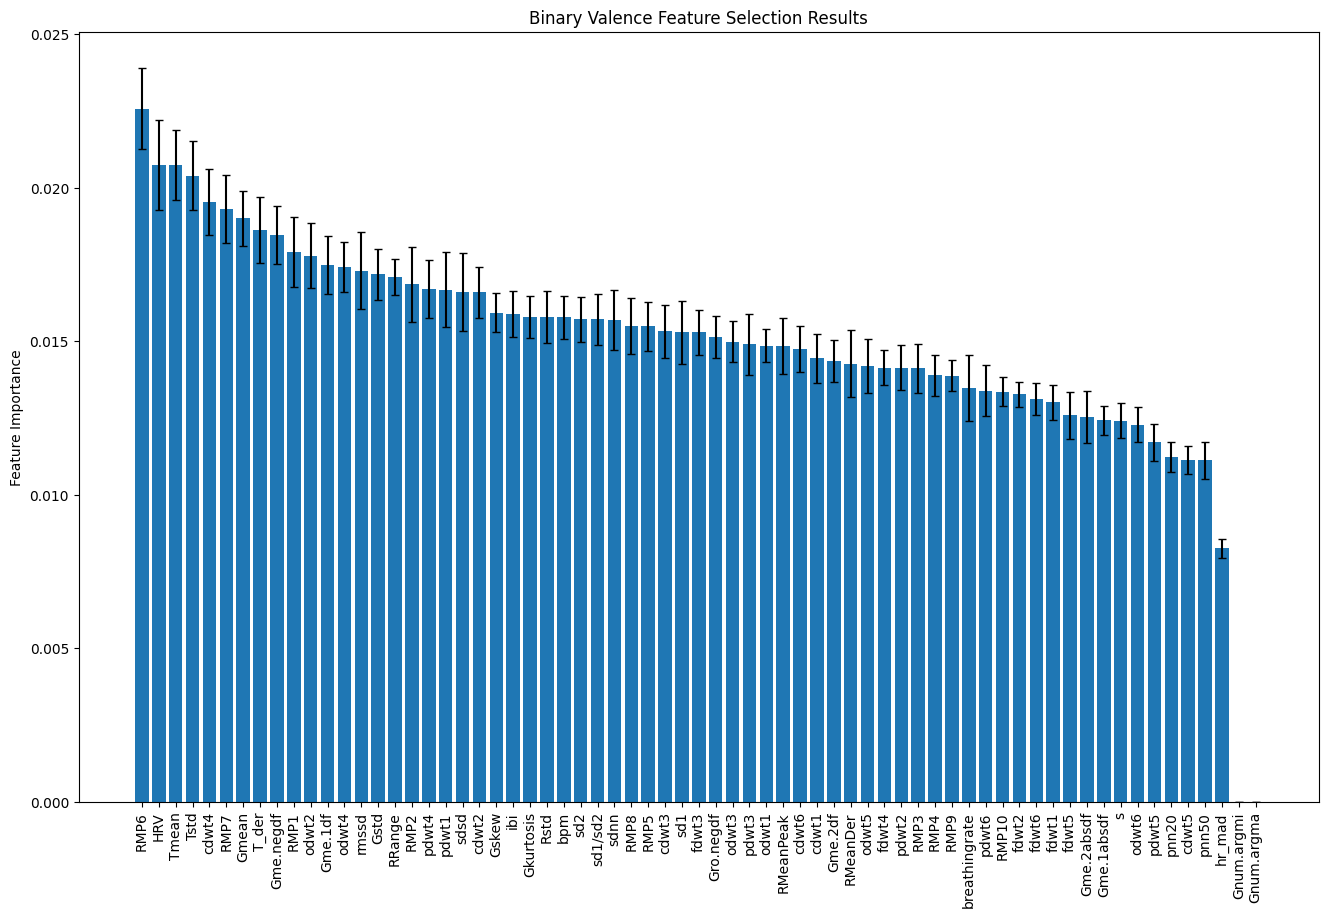

In [15]:
# plot feature importance results
feat_imps = np.vstack(feature_importance)
feat_imp_avg = feat_imps.mean(0)
feat_imp_std = feat_imps.std(0)

sorted_imps_idx = np.argsort(feat_imp_avg)
sorted_imps_idx = np.flip(sorted_imps_idx)
sorted_imp_avg = feat_imp_avg[sorted_imps_idx]
sorted_imp_std = feat_imp_std[sorted_imps_idx]
sorted_feat_names = feat_names[sorted_imps_idx]

x_pos = np.arange(len(feat_names))

best_val_feats = sorted_imps_idx[:10]
best_val_feats_names = sorted_feat_names[:10]

fig,ax = plt.subplots(figsize=(16,10))
ax.bar(x_pos,sorted_imp_avg,yerr=sorted_imp_std,align='center',ecolor='black',capsize=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_feat_names,rotation=90)
ax.set_title('Binary Valence Feature Selection Results')
ax.set_ylabel('Feature Importance')
plt.savefig('Feature_Importance_updated.png')

#Arousal Binary Classifier

In [16]:
# implements leave one (subject) out cross validation
prec = []
recall = []
f1 = []
acc = []
feature_importance = []
for j in np.unique(data[:,0]):
    row_idx = data[:,0] == j
    keep_idx = ~row_idx
    x_train = data[keep_idx,1:]
    y_train = y_arousal[keep_idx,0]
    x_val = data[row_idx,1:]
    y_val = y_arousal[row_idx,0]
    model = RandomForestClassifier(n_estimators=1000)
    print(x_train.shape)
    print(np.unique(y_train))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    acc.append(skm.accuracy_score(y_val,y_pred))
    f1.append(skm.f1_score(y_val,y_pred))
    prec.append(skm.precision_score(y_val,y_pred))
    recall.append(skm.recall_score(y_val,y_pred))
    feature_importance.append(model.feature_importances_)

(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(549, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(544, 67)
[0. 1.]
(570, 67)
[0. 1.]
(566, 67)
[0. 1.]
(546, 67)
[0. 1.]
(541, 67)
[0. 1.]
(543, 67)
[0. 1.]
(558, 67)
[0. 1.]
(542, 67)
[0. 1.]
(554, 67)
[0. 1.]
(541, 67)
[0. 1.]
(577, 67)
[0. 1.]


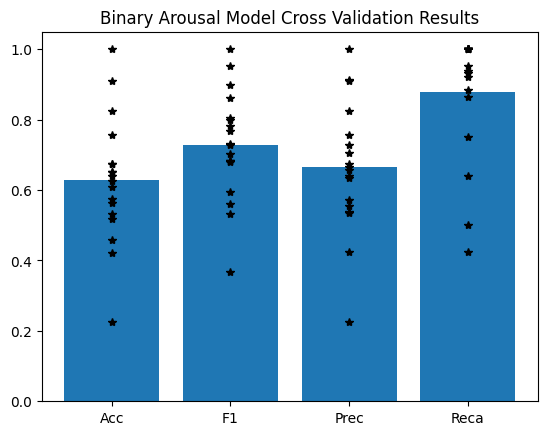

In [17]:
# plot performance results
acc_avg = np.mean(acc)
f1_avg = np.mean(f1)
prec_avg = np.mean(prec)
recall_avg = np.mean(recall)

acc_std = np.std(acc)
f1_std = np.std(f1)
prec_std = np.std(prec)
recall_std = np.std(recall)

means = [acc_avg,f1_avg,prec_avg,recall_avg]
errors = [acc_std,f1_std,prec_std,recall_std]
x_pos = np.arange(len(means))
mets = ['Acc','F1','Prec','Reca']

fig,ax = plt.subplots()
ax.bar(x_pos,means,align='center',ecolor='black',capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(mets)
ax.set_title('Binary Arousal Model Cross Validation Results')
ax.plot(np.zeros((len(acc),1)),acc,'*k')
ax.plot(np.ones((len(f1),1)),f1,'*k')
ax.plot(np.ones((len(prec),1))*2,prec,'*k')
ax.plot(np.ones((len(recall),1))*3,recall,'*k')

In [18]:
subjs = np.unique(data[:,0])
print(len(subjs))
idx = np.where(np.array(acc)<.5)
print(subjs[idx])
print('mean acc:' , acc_avg)

18
[ 7. 15. 17.]
mean acc: 0.628228683312271


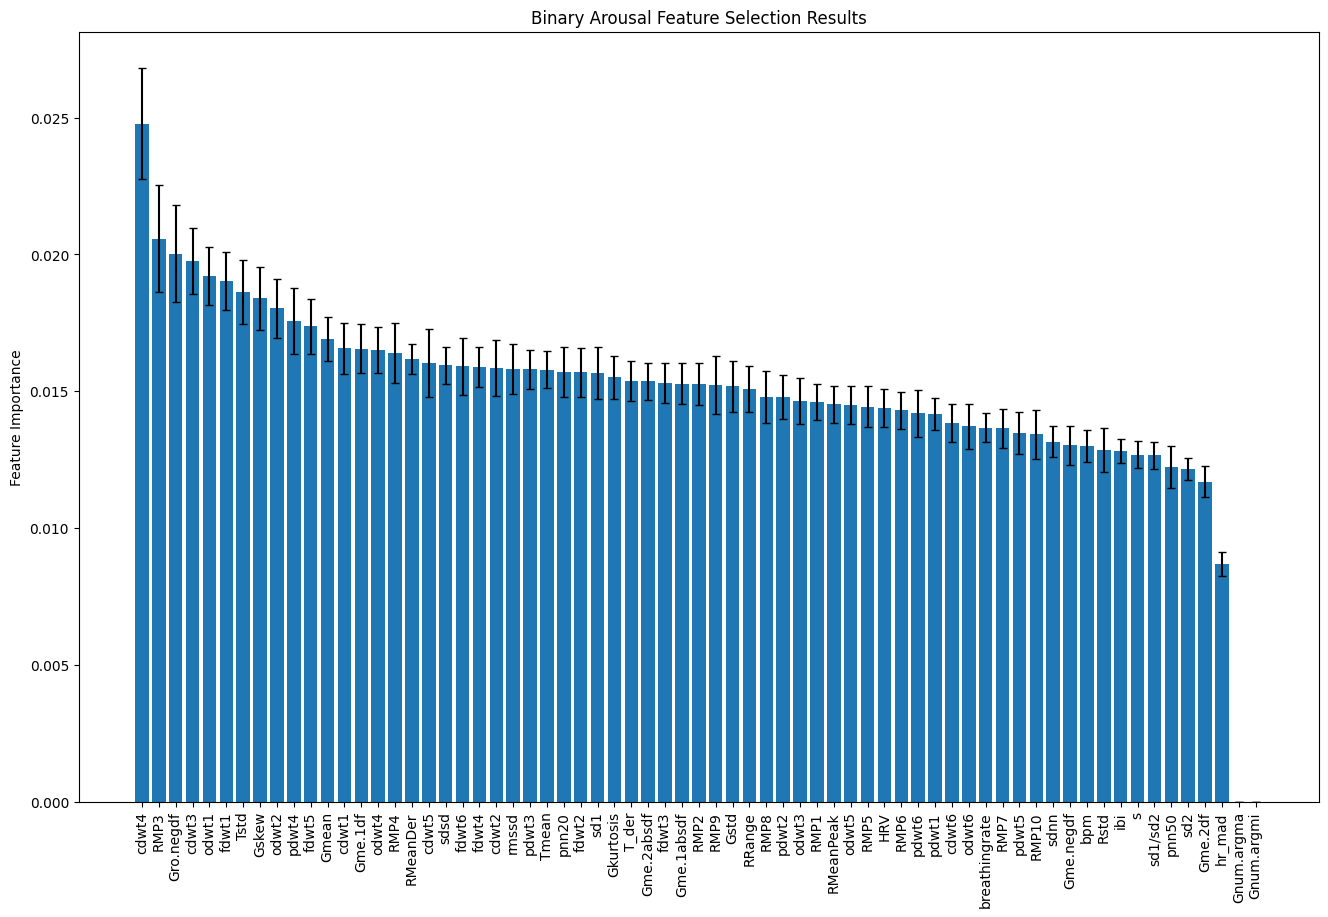

In [19]:
# plot feature importance results
feat_imps = np.vstack(feature_importance)
feat_imp_avg = feat_imps.mean(0)
feat_imp_std = feat_imps.std(0)

sorted_imps_idx = np.argsort(feat_imp_avg)
sorted_imps_idx = np.flip(sorted_imps_idx)
sorted_imp_avg = feat_imp_avg[sorted_imps_idx]
sorted_imp_std = feat_imp_std[sorted_imps_idx]
sorted_feat_names = feat_names[sorted_imps_idx]

x_pos = np.arange(len(feat_names))

best_ar_feats = sorted_imps_idx[:10]
best_ar_feats_names = sorted_feat_names[:10]

fig,ax = plt.subplots(figsize=(16,10))
ax.bar(x_pos,sorted_imp_avg,yerr=sorted_imp_std,align='center',ecolor='black',capsize=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_feat_names,rotation=90)
ax.set_title('Binary Arousal Feature Selection Results')
ax.set_ylabel('Feature Importance')
plt.savefig('Feature_Importance_updated.png')

#Multiclass Classifer

In [20]:
# implements leave one (subject) out cross validation
prec = []
recall = []
f1 = []
acc = []
feature_importance = []
for j in np.unique(data[:,0]):
    row_idx = data[:,0] == j
    keep_idx = ~row_idx
    x_train = data[keep_idx,1:]
    y_train = y_multi[keep_idx]
    x_val = data[row_idx,1:]
    y_val = y_multi[row_idx]
    model = RandomForestClassifier(n_estimators=1000)
    print(x_train.shape)
    print(np.unique(y_train))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    acc.append(skm.accuracy_score(y_val,y_pred))
    f1.append(skm.f1_score(y_val,y_pred,average='weighted'))
    prec.append(skm.precision_score(y_val,y_pred,average='weighted'))
    recall.append(skm.recall_score(y_val,y_pred,average='weighted'))
    feature_importance.append(model.feature_importances_)

(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(549, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(541, 67)
[0. 1.]
(544, 67)
[0. 1.]
(570, 67)
[0. 1.]
(566, 67)
[0. 1.]
(546, 67)
[0. 1.]
(541, 67)
[0. 1.]
(543, 67)
[0. 1.]
(558, 67)
[0. 1.]
(542, 67)
[0. 1.]
(554, 67)
[0. 1.]
(541, 67)
[0. 1.]
(577, 67)
[0. 1.]


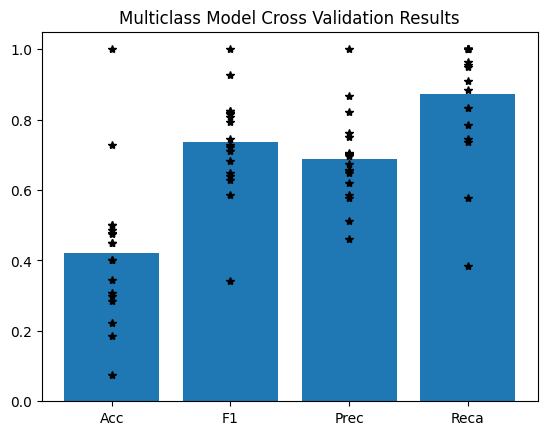

In [21]:
# plot performance results
acc_avg = np.mean(acc)
f1_avg = np.mean(f1)
prec_avg = np.mean(prec)
recall_avg = np.mean(recall)

acc_std = np.std(acc)
f1_std = np.std(f1)
prec_std = np.std(prec)
recall_std = np.std(recall)

means = [acc_avg,f1_avg,prec_avg,recall_avg]
errors = [acc_std,f1_std,prec_std,recall_std]
x_pos = np.arange(len(means))
mets = ['Acc','F1','Prec','Reca']

fig,ax = plt.subplots()
ax.bar(x_pos,means,align='center',ecolor='black',capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(mets)
ax.set_title('Multiclass Model Cross Validation Results')
ax.plot(np.zeros((len(acc),1)),acc,'*k')
ax.plot(np.ones((len(f1),1)),f1,'*k')
ax.plot(np.ones((len(prec),1))*2,prec,'*k')
ax.plot(np.ones((len(recall),1))*3,recall,'*k')

In [22]:
subjs = np.unique(data[:,0])
print(len(subjs))
idx = np.where(np.array(acc)<.5)
print(subjs[idx])
print('mean acc:' , acc_avg)

18
[ 5.  7.  8.  9. 10. 12. 14. 15. 16. 17. 18. 19. 20. 21.]
mean acc: 0.42142274584827977


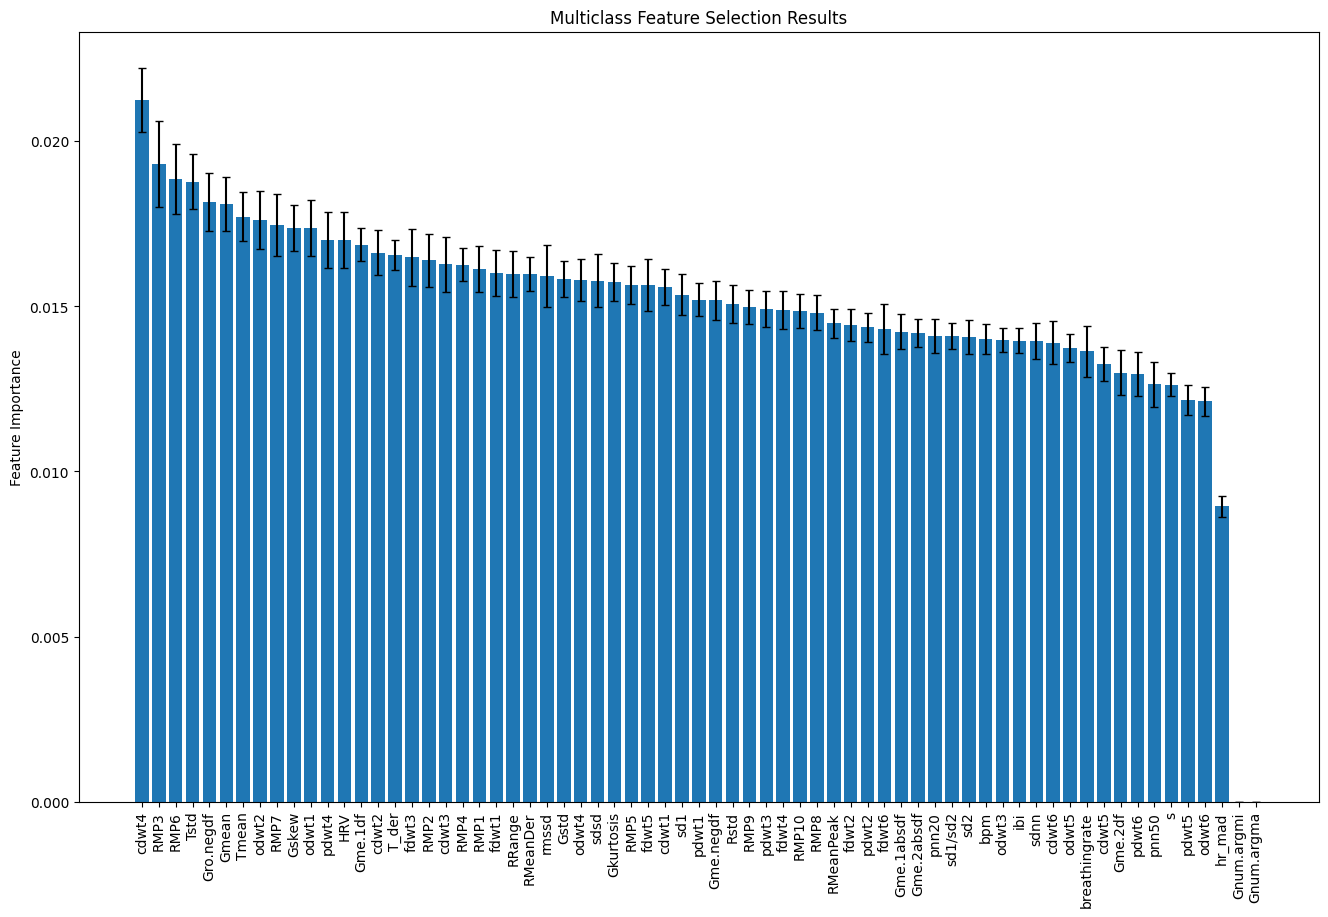

In [23]:
# plot feature importance results
feat_imps = np.vstack(feature_importance)
feat_imp_avg = feat_imps.mean(0)
feat_imp_std = feat_imps.std(0)

sorted_imps_idx = np.argsort(feat_imp_avg)
sorted_imps_idx = np.flip(sorted_imps_idx)
sorted_imp_avg = feat_imp_avg[sorted_imps_idx]
sorted_imp_std = feat_imp_std[sorted_imps_idx]
sorted_feat_names = feat_names[sorted_imps_idx]

x_pos = np.arange(len(feat_names))

best_multi_feats = sorted_imps_idx[:10]
best_multi_feats_names = sorted_feat_names[:10]

fig,ax = plt.subplots(figsize=(16,10))
ax.bar(x_pos,sorted_imp_avg,yerr=sorted_imp_std,align='center',ecolor='black',capsize=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_feat_names,rotation=90)
ax.set_title('Multiclass Feature Selection Results')
ax.set_ylabel('Feature Importance')
plt.savefig('Feature_Importance_updated.png')

#Train SVC on subset of important features

In [24]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [25]:
best_feats = np.hstack([best_val_feats,best_ar_feats,best_multi_feats])
best_feats.shape
best_uniq = np.unique(best_feats)
best_uniq.shape
print(feat_names[best_uniq])
reduced_data = data[:,1:]
reduced_data = reduced_data[:,best_uniq]
reduced_data = np.hstack([data[:,0].reshape((data.shape[0],1)),reduced_data])
reduced_data.shape

['RMP1' 'RMP3' 'RMP6' 'RMP7' 'Tmean' 'Tstd' 'T_der' 'HRV' 'Gmean' 'Gskew'
 'Gme.negdf' 'Gro.negdf' 'cdwt3' 'cdwt4' 'fdwt1' 'odwt1' 'odwt2' 'pdwt4']


(581, 19)

In [41]:
y_svc = y_multi[:,0]*2+y_multi[:,1]
print(y_svc.shape)
print(np.sum(y_multi[:,0]))
print(np.sum(y_multi[:,1]))

(581,)
364.0
358.0


In [ ]:
# implements leave one (subject) out cross validation
prec = []
recall = []
f1 = []
acc = []
matrix = np.zeros([4,4])
for j in np.unique(reduced_data[:,0]):
    row_idx = reduced_data[:,0] == j
    keep_idx = ~row_idx
    x_train = reduced_data[keep_idx,1:]
    y_train = y_svc[keep_idx]
    x_val = reduced_data[row_idx,1:]
    y_val = y_svc[row_idx]
    #model = make_pipeline(StandardScaler(),SVC(gamma='auto',kernel='poly'))
    model = SVC(gamma='auto',kernel='poly')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    acc.append(skm.accuracy_score(y_val,y_pred))
    f1.append(skm.f1_score(y_val,y_pred,average='weighted'))
    prec.append(skm.precision_score(y_val,y_pred,average='weighted'))
    recall.append(skm.recall_score(y_val,y_pred,average='weighted'))
    print(y_pred)
    print(y_val)

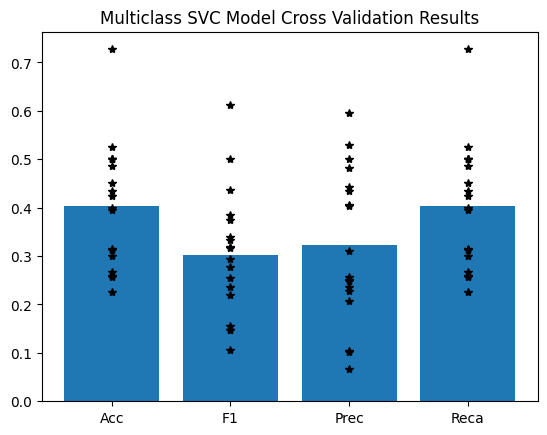

In [28]:
# plot performance results
acc_avg = np.mean(acc)
f1_avg = np.mean(f1)
prec_avg = np.mean(prec)
recall_avg = np.mean(recall)

acc_std = np.std(acc)
f1_std = np.std(f1)
prec_std = np.std(prec)
recall_std = np.std(recall)

means = [acc_avg,f1_avg,prec_avg,recall_avg]
errors = [acc_std,f1_std,prec_std,recall_std]
x_pos = np.arange(len(means))
mets = ['Acc','F1','Prec','Reca']

fig,ax = plt.subplots()
ax.bar(x_pos,means,align='center',ecolor='black',capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(mets)
ax.set_title('Multiclass SVC Model Cross Validation Results')
ax.plot(np.zeros((len(acc),1)),acc,'*k')
ax.plot(np.ones((len(f1),1)),f1,'*k')
ax.plot(np.ones((len(prec),1))*2,prec,'*k')
ax.plot(np.ones((len(recall),1))*3,recall,'*k')

In [29]:
subjs = np.unique(data[:,0])
print(len(subjs))
idx = np.where(np.array(acc)<.5)
print(subjs[idx])
print('mean acc:' , acc_avg)


18
[ 5.  7.  8. 10. 12. 14. 15. 16. 17. 18. 19. 20. 21.]
mean acc: 0.4043000311767792


In [30]:
print(y_pred)
print(y_val)


[3. 0. 3. 3.]
[3. 3. 2. 3.]


In [31]:
len(acc)

18

In [32]:
from sklearn.metrics import confusion_matrix

In [34]:
confusion_matrix(y_val,y_pred)[0

array([[0, 0, 2],
       [0, 0, 1],
       [0, 0, 8]], dtype=int64)

In [36]:
np.unique(y_val)


array([1., 2., 3.])

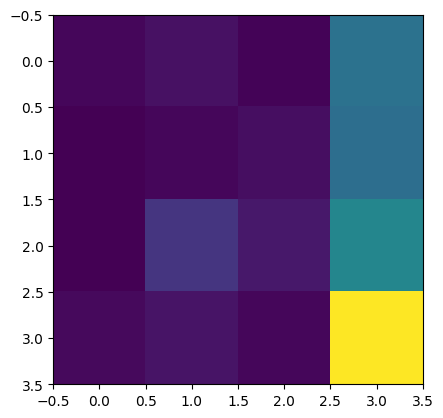

In [37]:
plt.imshow(matrix)

In [38]:
np.unique(y_pred)

array([3.])